# Learning b-splines

Let us now firstly define the basic building blocks aka splines  

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def extend_knots(knots, spline_order):
    """
    Extends the knots on either side by spline_order steps.

    Args:
        knots (numpy.ndarray): Array of control points of shape (number of control points,).
        spline_order (int): Spline order.

    Returns:
        numpy.ndarray: Extended knots of shape (number of control points + 2 * spline_order,).
    """
    n_intervals = knots.shape[-1] - 1
    bucket_size = (knots[-1] - knots[0]) / n_intervals

    for _ in range(spline_order):
        knots = np.concatenate(([knots[0] - bucket_size], knots))
        knots = np.concatenate((knots, [knots[-1] + bucket_size]))

    return knots

def evaluate_basis_functions(x_eval, knots, spline_order):
    """
    Evaluates basis functions for order-k splines with control points defined in knots.

    Args:
        x_eval (numpy.ndarray): Evaluation points of shape (number of samples,).
        knots (numpy.ndarray): Control points of shape (number of control points,).
        spline_order (int): Order of spline.

    Returns:
        numpy.ndarray: Basis function values of shape (number of samples, number of basis functions).
    """
    knots_ = extend_knots(knots, spline_order)
    knots_ = knots_[:, np.newaxis]  # Shape: (number of control points + 2 * spline_order, 1)
    x_ = x_eval[np.newaxis, :]      # Shape: (1, number of samples)

    for idx in range(spline_order + 1):
        if idx == 0:
            bases = ((x_ >= knots_[:-1]) & (x_ < knots_[1:])).astype(float)
        else:
            numerator1 = x_ - knots_[:-idx - 1]
            denominator1 = knots_[1:-idx] - knots_[:-idx - 1]
            factor1 = np.divide(numerator1, denominator1, out=np.zeros_like(numerator1), where=denominator1 != 0)
            bases1 = factor1 * bases[:-1]

            numerator2 = knots_[idx + 1:] - x_
            denominator2 = knots_[idx + 1:] - knots_[1:-idx]
            factor2 = np.divide(numerator2, denominator2, out=np.zeros_like(numerator2), where=denominator2 != 0)
            bases2 = factor2 * bases[1:]

            bases = bases1 + bases2

    bases = bases.T  # Shape: (number of samples, number of basis functions)
    return bases


Knots: Shape: (10,), values: [-1.         -0.77777778 -0.55555556 -0.33333333 -0.11111111  0.11111111
  0.33333333  0.55555556  0.77777778  1.        ]
x: Shape: (1000,), values: [-1.         -0.997998   -0.995996   -0.99399399 -0.99199199]
k=0, number of basis functions: 9
k=1, number of basis functions: 10
k=2, number of basis functions: 11
k=3, number of basis functions: 12


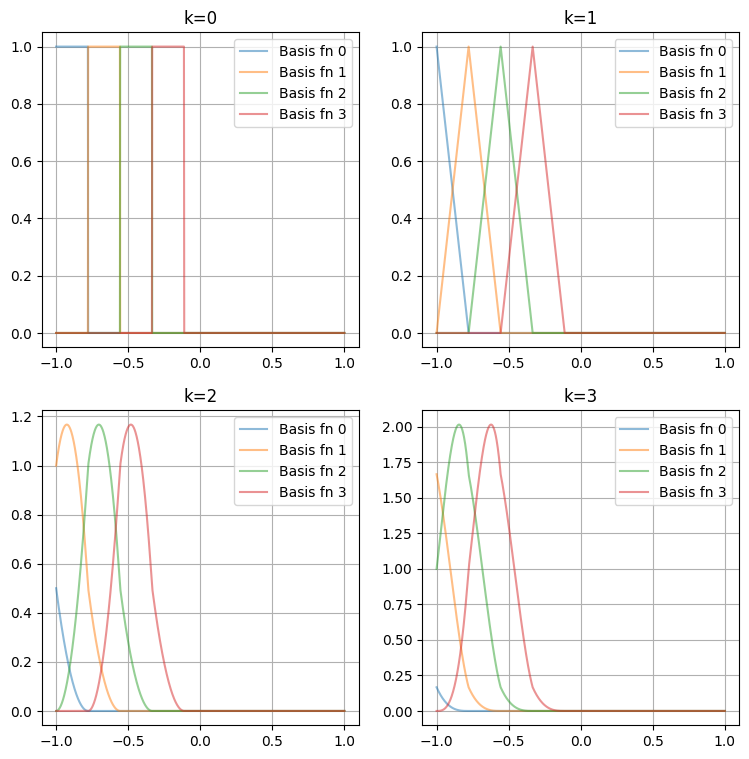

In [ ]:
# Define knots and evaluation points 
knots = np.linspace(-1, 1, num=10)
x = np.linspace(-1, 1, num=1000)

print(f"Knots: Shape: {knots.shape}, values: {knots}")
print(f"x: Shape: {x.shape}, values: {x[:5]}")

# Evaluate basis functions for different spline orders
value1 = evaluate_basis_functions(x, knots, spline_order=0)
value2 = evaluate_basis_functions(x, knots, spline_order=1)
value3 = evaluate_basis_functions(x, knots, spline_order=2)
value4 = evaluate_basis_functions(x, knots, spline_order=3)

print(f"k=0, number of basis functions: {value1.shape[-1]}")
print(f"k=1, number of basis functions: {value2.shape[-1]}")
print(f"k=2, number of basis functions: {value3.shape[-1]}")
print(f"k=3, number of basis functions: {value4.shape[-1]}")

# Plotting the basis functions
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 9), dpi=100)

n_basis_to_plot = 4
all_basis = [(value1, 'k=0'), (value2, 'k=1'), (value3, 'k=2'), (value4, 'k=3')]

for i in range(8):
    ax = axs[i // 2, i % 2]
    value, label = all_basis[i]
    for idx in range(min(n_basis_to_plot, value.shape[1])):
        ax.plot(x, value[:, idx], label=f"Basis fn {idx}", alpha=0.5)
    ax.grid()
    ax.set_title(label)
    ax.legend()

plt.show()

## Learning the Activation Function, i.e., Coefficients

To approximate a given function $f(x)$ using a set of basis functions, we formulate the problem as a linear system where we aim to find the optimal coefficients $\{c_i\}_{i=0}^n$. These coefficients allow us to express $f(x)$ as:

$$
f(x) = \sum_{i=0}^n c_i \cdot N_i(x),
$$

where:
- $N_i(x)$ are the basis functions, which are predefined and evaluated deterministically at given input values $x$,
- $c_i$ are the unknown coefficients we seek to compute.

### Linear System Formulation

Given a set of input points $\{x_j\}_{j=1}^m$, the basis functions can be evaluated to form a matrix $N$ of size $m \times (n+1)$, where:

$$
N_{j,i} = N_i(x_j), \quad 1 \leq j \leq m, \, 0 \leq i \leq n.
$$

The target function values at the input points are represented as a vector $\mathbf{f} \in \mathbb{R}^m$, where:

$$
\mathbf{f}_j = f(x_j), \quad 1 \leq j \leq m.
$$

The coefficients $\mathbf{c} \in \mathbb{R}^{n+1}$ are the unknowns we aim to compute. The relationship between the inputs, basis functions, and the target function can now be written as the matrix equation:

$$
N \mathbf{c} = \mathbf{f}.
$$

### Least-Squares Approximation

In general, the system $N \mathbf{c} = \mathbf{f}$ may not have an exact solution, especially when $m > n+1$ (i.e., the system is overdetermined). In this case, we seek the coefficients $\mathbf{c}$ that minimize the residual error:

$$
\min_{\mathbf{c}} \| N \mathbf{c} - \mathbf{f} \|_2,
$$

where $\| \cdot \|_2$ is the Euclidean norm. This formulation defines the least-squares problem.

### Solving the Least-Squares Problem

The solution to the least-squares problem is given by:

$$
\mathbf{c} = (N^\top N)^{-1} N^\top \mathbf{f},
$$

where:
- $N^\top$ is the transpose of $N$,
- $(N^\top N)^{-1}$ is the inverse of the Gram matrix $N^\top N$, assuming it is nonsingular.

This equation ensures that $\mathbf{c}$ minimizes the squared error between the predicted function values $N \mathbf{c}$ and the true function values $\mathbf{f}$.

### Interpretation of the Solution

The vector $\mathbf{c}$ represents the coefficients that define the best-fit linear combination of the basis functions $N_i(x)$ to approximate the target function $f(x)$ in the least-squares sense. The residual error $\mathbf{r}$ is defined as:

$$
\mathbf{r} = \mathbf{f} - N \mathbf{c},
$$

and the total error is given by:

$$
\|\mathbf{r}\|_2^2 = \| \mathbf{f} - N \mathbf{c} \|_2^2.
$$

### Basis Functions and System Properties

The choice of basis functions $N_i(x)$ and their evaluation points $x_j$ affects the structure of the matrix $N$ and, consequently, the quality of the approximation. Common properties to consider include:
- **Conditioning of $N$**: If the columns of $N$ are nearly linearly dependent, $(N^\top N)$ becomes ill-conditioned, leading to unstable solutions.
- **Number of basis functions**: Increasing $n$ provides more flexibility but may lead to overfitting if $n \geq m$.

The least-squares solution provides a robust method for approximating $f(x)$ by balancing these trade-offs.

### Key Results

The least-squares framework guarantees that:
1. The solution $\mathbf{c}$ minimizes the squared error between the approximation and the target function.
2. The solution is unique if $N^\top N$ is invertible.
3. The error decreases as the number of basis functions increases, provided the system remains well-conditioned.


Estimated coefficients: [-0.59692155 -0.18705262  0.41393682  0.30218539 -0.29347683 -0.41205343
  0.15467041  0.46294921  0.0088788  -0.46395253 -0.1629429   0.40681655]


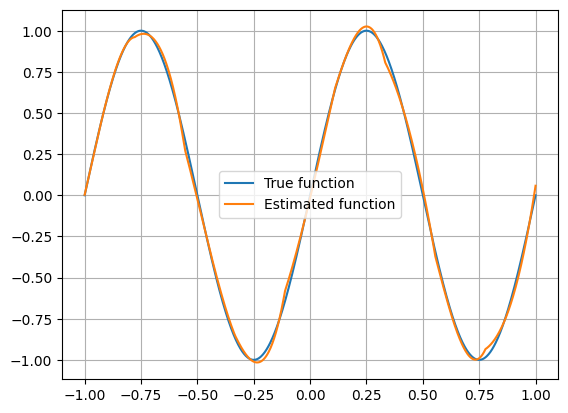

In [34]:
k = 3
knots = np.linspace(-1, 1, num=10)
x = np.linspace(-1, 1, num=1000)
value = evaluate_basis_functions(x, knots, spline_order=k)

fn = lambda x: np.sin(2 * np.pi * x)

# Solve using least squares
coeffs = np.linalg.lstsq(value, fn(x), rcond=None)[0]
print(f"Estimated coefficients: {coeffs}")

y_pred = np.dot(value, coeffs)

# Plot the function and the spline
plt.plot(x, fn(x), label="True function")
plt.plot(x, y_pred, label="Estimated function")
plt.grid()
plt.legend()
plt.show()

